In [21]:
# # RAMI Benchmarking 
# The goal of the RAMI4PILPS experiment[^1] is to evaluate different approaches by which Land Surface Models in larger Earth System Models quantify the radiation transfer within vegetation canopies. The RAMI4PILPS can be interpreted as a quality control mechanism used to: 

#1) quantify the errors in the radiative transfer scheme; 
#2) identify the impact that structural and spectral sub-grid variability may have on radiative transfer; and 
#3) verify the conservation of energy at the level of the surface, as well as inconsistencies arising from different levels of assumptions/simplifications. 

#This approach involves direct comparison with reference solutions obtained from highly accurate 3D models identified during the third phase of the RAMI benchmarking exercise[^2]. 

#A set of 3D experiments compares the partitioning of incident solar energy into an absorbed (A) flux, a transmitted (T) flux component and the surface reflectance (R). The overall canopy structure for these test cases is reminiscent of open forest canopies with randomly oriented foliage, confined to spherical volumes located at varying heights above the ground.
#In here, we use a total of 36 test cases including various canopy density, soil brightness, and illumination conditions for the visible (VIS) (400-700nm) and near infra-red (NIR) (700-3000nm) spectral ranges. 

# [^1]: J.L. Widlowski, B. Pinty, M. Clerici, Y. Dai, M. De Kauwe, K. de Ridder, A. Kallel, H. Kobayashi, T. Lavergne, W. Ni-Meister, A. Olchev, T. Quaife, S. Wang, W. Yang, Y. Yang, and H. Yuan (2011), RAMI4PILPS: An intercomparison of formulations for the partitioning of solar radiation in land surface models, Journal of Geophysical Research, 116, G02019, 25, DOI: 10.1029/2010JG001511. 
# [^2]: Widlowski, J-L., M. Taberner, B. Pinty, V. Bruniquel-Pinel, M. Disney, R. Fernandes, J.-P. Gastellu-Etchegorry, N. Gobron, A. Kuusk, T. Lavergne, S. Leblanc, P. Lewis, E. Martin, M. Mottus, P. J. R. North, W. Qin, M.Robustelli, N. Rochdi, R.Ruiloba, C.Soler, R.Thompson, W. Verhoef, M. M.Verstraete, and D. Xie (2007), 'The third RAdiation transfer Model Intercomparison (RAMI) exercise: Documenting progress in canopy reflectance modelling', Journal of Geophysical Research, 112, D09111, 28, DOI: 10.1029/2006JD007821. 


## Use Julia Plots package and switch to plotly js option:
using Plots
pyplot()

#----------------------------------------------------------------------------

# First, we include Revise (good for debugging) and Parameters (tools for structures)

#using Revise
using Parameters
#----------------------------------------------------------------------------

# Now include the Land modules

using Land
using Land.CanopyRT
#----------------------------------------------------------------------------

In [10]:
RAMI_SZA = [27.,60.,83.]

RAMI_fabsRed_050_BLK =  [0.09380509999999999, 0.16259713, 0.53931207]
RAMI_frefRed_050_BLK =  [0.00330673, 0.00517598, 0.01626682]
RAMI_ftranRed_050_BLK =  [0.90288817, 0.83222689, 0.44442110999999995]
RAMI_fabsRed_150_BLK =  [0.28137804, 0.46514268999999997, 0.89063486]
RAMI_frefRed_150_BLK =  [0.00923676, 0.01379672, 0.02970703]
RAMI_ftranRed_150_BLK =  [0.7093851999999999, 0.52106059, 0.07965811]
RAMI_fabsRed_250_BLK =  [0.46852539, 0.70426097, 0.9461774300000001]
RAMI_frefRed_250_BLK =  [0.01445858, 0.02016963, 0.03477486]
RAMI_ftranRed_250_BLK =  [0.51701603, 0.2755694, 0.01904771]
RAMI_fabsRed_050_MED =  [0.10897124, 0.17760124000000002, 0.54764719]
RAMI_frefRed_050_MED =  [0.09759354, 0.09107608, 0.06177913]
RAMI_ftranRed_050_MED =  [0.90337609, 0.83265704, 0.44469279]
RAMI_fabsRed_150_MED =  [0.31403827, 0.49003033, 0.89432051]
RAMI_frefRed_150_MED =  [0.06195053, 0.05151941, 0.03561715]
RAMI_ftranRed_150_MED =  [0.7104761399999999, 0.52197456, 0.07977039000000001]
RAMI_fabsRed_250_MED =  [0.50540545, 0.72429659, 0.94742381]
RAMI_frefRed_250_MED =  [0.03953053, 0.03315039, 0.03580858]
RAMI_ftranRed_250_MED =  [0.51811911, 0.27616192, 0.01909098]
RAMI_fabsRed_050_SNW =  [0.21471034, 0.28200132, 0.60564705]
RAMI_frefRed_050_SNW =  [0.7526521700000001, 0.6879087300000001, 0.37825442000000004]
RAMI_ftranRed_050_SNW =  [0.90659694, 0.83583194, 0.44718138]
RAMI_fabsRed_150_SNW =  [0.5431621799999999, 0.66519762, 0.9201217300000001]
RAMI_frefRed_150_SNW =  [0.43100610000000006, 0.31581022999999997, 0.07698033]
RAMI_ftranRed_150_SNW =  [0.71754777, 0.52755972, 0.08049832999999999]
RAMI_fabsRed_250_SNW =  [0.76512258, 0.86538802, 0.9562473199999999]
RAMI_frefRed_250_SNW =  [0.21595537, 0.124503, 0.043056080000000004]
RAMI_ftranRed_250_SNW =  [0.5256125, 0.280805, 0.01935]

3-element Array{Float64,1}:
 0.5256125
 0.280805 
 0.01935  

In [17]:
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRT.canopy.nlayers)
for i = 1:CanopyRT.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRT.fluspect!(arrayOfLeaves[i], CanopyRT.optis)
end

In [18]:
#Soil albedo
#BLK
CanopyRT.soil.albedo_SW[:] .=0.0;
#MED
#CanopyRTMod.soil.albedo_SW[:] .=0.1217;
#SNW
#CanopyRTMod.soil.albedo_SW[:] .=0.9640;


reflRed_SZA = []
reflNIR_SZA = []
absRed_SZA = []
absNIR_SZA = []
transRed_SZA = []
transNIR_SZA = []

#Clumping index
#Sparse
CanopyRT.canopy.Ω = 0.365864235
#Medium
#CanopyRTMod.canopy.Ω = 0.405417644
#Dense
#CanopyRTMod.canopy.Ω = 0.45946608

#CanopyRTMod.canopy.Ω = 1.0

#Viewing Zenith Angle in degrees
CanopyRT.angles.tto=0.0
#Leaf Area index
#Sparse
CanopyRT.canopy.LAI=0.50265
#Medium
#CanopyRTMod.canopy.LAI=1.5017
#Dense
#CanopyRTMod.canopy.LAI=2.5007

for SZA=0.0:1:85
    CanopyRT.angles.tts=SZA  

   CanopyRT.fluspect!(leaf, CanopyRT.optis)
   CanopyRT.computeCanopyGeomProps!(canopy, angles,canOpt)
   CanopyRT.computeCanopyMatrices!(arrayOfLeaves,canOpt);

   # leaf reflectance RED
   leaf.ρ_SW[28] = 0.0735
   # leaf transmittance
   leaf.τ_SW[28]= 0.0566 
    
   # leaf reflectance NIR
   leaf.ρ_SW[52] = 0.3912
   # leaf transmittance
   leaf.τ_SW[52]= 0.4146 
    
    CanopyRT.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRT.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(reflNIR_SZA, canRad.alb_direct[52])
    push!(absRed_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(absNIR_SZA, (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]))
    push!(transRed_SZA,  ((1. .- (sum(canRad.netSW_shade,dims=2)[28,1].+sum(canRad.netSW_sunlit,dims=2)[28,1])./(sunRad.E_diffuse[28].+sunRad.E_direct[28]) .- canRad.alb_direct[28])./(1. .- CanopyRT.soil.albedo_SW[1])))
    push!(transNIR_SZA,  ((1. .- (sum(canRad.netSW_shade,dims=2)[52,1].+sum(canRad.netSW_sunlit,dims=2)[52,1])./(sunRad.E_diffuse[52].+sunRad.E_direct[52]) .- canRad.alb_direct[52])./(1. .- CanopyRT.soil.albedo_SW[1])))
end


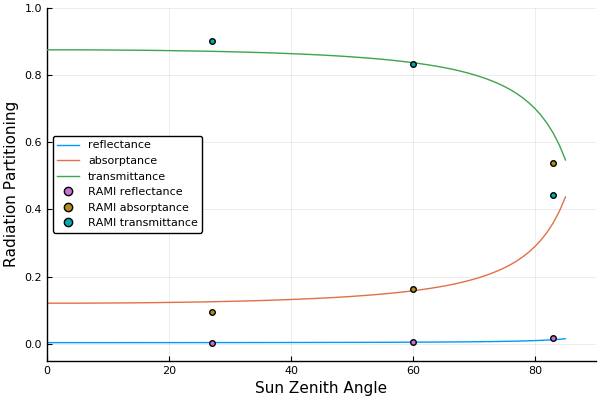

In [20]:
SZA=0:1:85

plot(SZA, reflRed_SZA,label="reflectance")
plot!(SZA, absRed_SZA,label="absorptance")
plot!(SZA, transRed_SZA,label="transmittance")

scatter!(RAMI_SZA, RAMI_frefRed_050_BLK,label="RAMI reflectance")
scatter!(RAMI_SZA, RAMI_fabsRed_050_BLK,label="RAMI absorptance")
scatter!(RAMI_SZA, RAMI_ftranRed_050_BLK,label="RAMI transmittance")
ylabel!("Radiation Partitioning")
xlabel!("Sun Zenith Angle")
plot!(xlims = (0.0, 90.), ylims = (-0.05, 1.0), xticks = 0:20:91., yticks = 0:0.2:1.0)